In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 21/11/2020

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 20/11/2020\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS, \
                                 from_HHMMSS_to_HH                                 
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt, \
                                  compute_start_end_timestamps_from_days_with_regulations
from generator import extract_features_from_list_days_and_timestamps, \
                      extract_days_timestamps_volumes_labels_days_with_regulations

from generator_weather import extract_weather_information_from_list_days_and_timestamps

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, TimeDistributed
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/fra

In [4]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [5]:
num_epochs = 200
batch_size = 32

# Prepare / Extreact data

###  Extract the available regulations

In [6]:
REGULATIONS = read_REGULATIONS_file('./20190604_20191020_REGULATIONS.csv')

"""
If the regulation contains a cancel_time -> It will be ignored
    * To take them into account -> Remove last condition
"""
REGULATIONS = REGULATIONS.loc[(REGULATIONS["regulation_reason"].isin([' C-ATC Capacity ', ' R-ATC Routeing '])) & 
                              (REGULATIONS["location_type"] == ' En route ') &
                              (REGULATIONS["cancel_time"] == '  ')
                             ] 

In [7]:
# TODO: Try to optimaze the following step (very slow)

# Drop all the regulations which are not associated to a "traffic_volume" == "MAS..."
count_drops = 0
for index, row in REGULATIONS.iterrows():
    
    # The .strip() is requieres because there is a white space at the beginning of the names
    if row["traffic_volume"].strip()[0:3] != 'MAS': 
        REGULATIONS = REGULATIONS.drop(index=index)
        count_drops += 1

In [8]:
print('Number ALL regulations from the given sector: ', str(len(REGULATIONS.values)))

Number ALL regulations from the given sector:  211


In [9]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS.loc[:, 'date_DDMMYYYY'] = REGULATIONS.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS.loc[:, 'start_time_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.start_time.strip()), axis=1)
REGULATIONS.loc[:, 'end_time_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.end_time.strip()), axis=1)
REGULATIONS.loc[:, 'start_time_study_HHMMSS'] = REGULATIONS.apply(lambda x: substract_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_before_start_time), axis=1)
REGULATIONS.loc[:, 'end_time_study_HHMMSS'] = REGULATIONS.apply(lambda x: add_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_after_start_time), axis=1)

In [10]:
# We want to remove from the DataFrame all the rows outside the valid interval of days
# Outside the date of the available AIRACS
min_date = date(2019, 6, 4)
# max_date = date(2019, 8, 14) 
max_date = date(2019, 9, 11) 


for index, row in REGULATIONS.iterrows():
        
    date_split = row["date_DDMMYYYY"].split("/") # 0 -> day; 1 -> month; 2 -> year
    date_object = date(int(date_split[2]), int(date_split[1]), int(date_split[0]))
    
    # Check if the regulation's date belong to the valid interval -> IF outside, drop the Regulation
    if date_object < min_date or date_object > max_date:
        REGULATIONS = REGULATIONS.drop(index=index)

In [11]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS.values)))

Number regulations AFTER pre-processing:  176


### Extract the different list of days and timestamps

##### Samples without regulations from days without regulations

In [12]:
# Extract the days with regulations
list_days_with_regulations = REGULATIONS["date_DDMMYYYY"].values

# Initialize a list with all the possible days and the final list for the days without regulations
list_all_possible_days = listDays_betweenTwoDates(min_date, max_date, 'DDMMYYYY', '/')
list_days_without_regulations = list()

In [13]:
# If a day does not appear in the list with reguilations -> No regulations for that day
for day in list_all_possible_days:
    if day not in list_days_with_regulations:
        list_days_without_regulations.append(day)

In [14]:
# For the days without regulations, we will generate random timestamps

list_days_without_regulations_extended = list()
start_time_samples_no_regulations = list()
end_time_samples_no_regulations = list()
list_volumes_no_regulations = list()

for day in list_days_without_regulations:
    # Iterate multiple time each day without regulations
    for _ in range(0,1):
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(random.randint(3,21))) # From 2 to 22 to avoid extrems (wrap around timestamps)
        minute = str("{:02d}".format(random.randint(0,59)))

        # Create the timestamp
        random_timestamps = hour + ":" + minute + ":" + '00'

        # Substract a given about to create the starting timestamp
        start_timestamp = substract_minutes_given_HHSSMM(random_timestamps, gap_before_start_time)
        start_time_samples_no_regulations.append(start_timestamp)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(random_timestamps, gap_after_start_time)
        end_time_samples_no_regulations.append(end_timestamp)

        # Due to no regulations were createcd for the given day, randomly select a volume
        index_random_volume = random.randint(0, REGULATIONS["traffic_volume"].values.shape[0]-1)
        random_volume = REGULATIONS.iloc[index_random_volume]["traffic_volume"][4:8] # To only save the suffix

        # Some "traffic_volumes" in the REGULATIONS file has different names than the "locations".
        # To avoid this error, we will manually parse this cases
        if random_volume == 'BALB':
            random_volume = 'BLUX'
    
        list_days_without_regulations_extended.append(day)
        list_volumes_no_regulations.append(random_volume)

In [15]:
len(list_days_without_regulations_extended), len(start_time_samples_no_regulations), \
len(end_time_samples_no_regulations), len(list_volumes_no_regulations)

(29, 29, 29, 29)

##### Sample with & without regulations from days with regulations completly random 
##### It is possible ta have sample with both categories (e.g. start NO Regs from Regs and then Reg)

In [16]:
REGULATIONS.loc[:, 'start_regulations_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.start_time.strip()), axis=1)
REGULATIONS.loc[:, 'end_regulations_HHMMSS'] = REGULATIONS.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.end_time.strip()), axis=1)

In [17]:
list_dates_with_regulations = REGULATIONS["date_DDMMYYYY"].values

start_regulations = REGULATIONS["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS["traffic_volume"].values

In [18]:
list_days_from_regulations, \
start_time_samples_days_from_regulations, \
end_time_samples_days_from_regulations, \
volumes_days_from_regulations, \
labels_days_from_regulations = extract_days_timestamps_volumes_labels_days_with_regulations(list_dates_with_regulations, 
                                                                      start_regulations,
                                                                      end_regulations,
                                                                      list_volumes_regulations, 
                                                                      gap_before_start_time, 
                                                                      gap_after_start_time, 
                                                                      num_additional_samples_per_day=20,
                                                                      min_timestamps_with_regulations=10)

In [19]:
len(list_days_from_regulations), len(start_time_samples_days_from_regulations), \
len(end_time_samples_days_from_regulations), len(volumes_days_from_regulations)

(967, 967, 967, 967)

In [26]:
i = -9  
list_days_without_regulations_extended[i], start_time_samples_no_regulations[i], \
end_time_samples_no_regulations[i], list_volumes_no_regulations[i]

('13/08/2019', '202700', '205700', 'D6WH')

False

In [39]:
i = 22
# i = 773
list_days_from_regulations[i], start_time_samples_days_from_regulations[i], \
end_time_samples_days_from_regulations[i], volumes_days_from_regulations[i]

('05/06/2019', '034000', '041000', 'B3EH')

In [33]:
list_days_from_regulations[10]

'05/06/2019'

In [38]:
volumes_days_from_regulations[22:]

['B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'BOLN',
 'BOLN',
 'BOLN',
 'BOLN',
 'BOLN',
 'BOLN',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'B3EH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'B5NL',
 'B5NL',
 'B5NL',
 'B5NL',
 'B5NL',
 'B5NL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'DHOL',
 'DHOL',
 'DHOL',
 'DHOL',
 'DHOL',
 'DHOL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'B3LL',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'D6WH',
 'BOLN',
 'BLUX',
 'BLUX',
 'BLUX',
 'B3LL',
 'B3LL',
 'B3LL',
 'D3WM',
 'D3WM',
 'D3WM',
 'D3WM',
 

### Extract all the features for the given dates and timestamps

In [20]:
list_days_without_regulations_extended = np.array(list_days_without_regulations_extended)
start_time_samples_no_regulations = np.array(start_time_samples_no_regulations)
end_time_samples_no_regulations = np.array(end_time_samples_no_regulations)
list_volumes_no_regulations = np.array(list_volumes_no_regulations)

In [21]:
X_days_without_regulations = np.zeros((len(list_days_without_regulations_extended), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       11))
X_days_without_regulations.shape

(29, 30, 11)

In [22]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(list_days_without_regulations_extended, 
                                                                           start_time_samples_no_regulations, 
                                                                           end_time_samples_no_regulations,
                                                                           list_volumes_no_regulations,
                                                                           gap_before_start_time, gap_after_start_time,
                                                                           X_days_without_regulations)

BLUX | counter: 1
BOLN | counter: 2
BLUX | counter: 3
BLUX | counter: 4
B3EH | counter: 5
D6WH | counter: 6
B3LL | counter: 7
B3LL | counter: 8
D3WM | counter: 9
BLUX | counter: 10
B3LL | counter: 11
B3EH | counter: 12
B3EH | counter: 13
B5KL | counter: 14
B3EH | counter: 15
BOLN | counter: 16
B5KL | counter: 17
D6WH | counter: 18
B3LL | counter: 19
BOLN | counter: 20
D6WH | counter: 21
B3LL | counter: 22
BLUX | counter: 23
BLUX | counter: 24
B3EH | counter: 25
B3LL | counter: 26
B3EH | counter: 27
B3EH | counter: 28
B3LL | counter: 29


In [23]:
np.save('./Counting_variables/Weather/X_days_without_regulations', X_days_without_regulations)

In [24]:
list_days_from_regulations = np.array(list_days_from_regulations)
start_time_samples_days_from_regulations = np.array(start_time_samples_days_from_regulations)
end_time_samples_days_from_regulations = np.array(end_time_samples_days_from_regulations)
volumes_days_from_regulations = np.array(volumes_days_from_regulations)

In [25]:
# Avoid a non existeing name of TV in our data
for i in range(len(volumes_days_from_regulations)):
    if volumes_days_from_regulations[i] == 'BALB':
        volumes_days_from_regulations[i] = 'BLUX'

In [26]:
X_days_from_regulations = np.zeros((len(list_days_from_regulations), int(gap_before_start_time+gap_after_start_time), 11))
X_days_from_regulations.shape

(967, 30, 11)

In [27]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(list_days_from_regulations, 
                                                                       start_time_samples_days_from_regulations, 
                                                                       end_time_samples_days_from_regulations,
                                                                       volumes_days_from_regulations,
                                                                       gap_before_start_time, gap_after_start_time,
                                                                       X_days_from_regulations)

D6WH | counter: 1
D6WH | counter: 2
D6WH | counter: 3
D6WH | counter: 4
D6WH | counter: 5
D6WH | counter: 6
D6WH | counter: 7
D6WH | counter: 8
D6WH | counter: 9
D6WH | counter: 10
D6WH | counter: 11
D6WH | counter: 12
D6WH | counter: 13
D6WH | counter: 14
D6WH | counter: 15
D6WH | counter: 16
D6WH | counter: 17
D6WH | counter: 18
D6WH | counter: 19
BOLN | counter: 20
BOLN | counter: 21
B3EH | counter: 22
B3EH | counter: 23
B3EH | counter: 24
B3EH | counter: 25
B3EH | counter: 26
B3EH | counter: 27
BOLN | counter: 28
BOLN | counter: 29
BOLN | counter: 30
BOLN | counter: 31
BOLN | counter: 32
BOLN | counter: 33
D6WH | counter: 34
D6WH | counter: 35
D6WH | counter: 36
D6WH | counter: 37
D6WH | counter: 38
D6WH | counter: 39
D6WH | counter: 40
D6WH | counter: 41
D6WH | counter: 42
D6WH | counter: 43
D6WH | counter: 44
B3LL | counter: 45
B3LL | counter: 46
B3LL | counter: 47
B3LL | counter: 48
B3LL | counter: 49
B3EH | counter: 50
B3EH | counter: 51
B3EH | counter: 52
B3EH | counter: 53
B3

BLUX | counter: 417
BLUX | counter: 418
BLUX | counter: 419
BLUX | counter: 420
BLUX | counter: 421
B3LL | counter: 422
B3LL | counter: 423
B3LL | counter: 424
B3LL | counter: 425
B3LL | counter: 426
B3LL | counter: 427
B3LL | counter: 428
DWST | counter: 429
DWST | counter: 430
DWST | counter: 431
DWST | counter: 432
DWST | counter: 433
B5KL | counter: 434
B5KL | counter: 435
B5KL | counter: 436
B5KL | counter: 437
B3EH | counter: 438
B3EH | counter: 439
B3EH | counter: 440
B5WH | counter: 441
D6WH | counter: 442
D6WH | counter: 443
D6WH | counter: 444
D6WH | counter: 445
D6WH | counter: 446
D6WH | counter: 447
D6WH | counter: 448
D6WH | counter: 449
D6WH | counter: 450
D6WH | counter: 451
D6WH | counter: 452
D6WH | counter: 453
D6WH | counter: 454
D6WH | counter: 455
D6WH | counter: 456
D6WH | counter: 457
D6WH | counter: 458
D6WH | counter: 459
D6WH | counter: 460
D6WH | counter: 461
D6WH | counter: 462
D6WH | counter: 463
BLUX | counter: 464
BLUX | counter: 465
BLUX | counter: 466


BOLN | counter: 827
BOLN | counter: 828
BOLN | counter: 829
BOLN | counter: 830
BOLN | counter: 831
BOLN | counter: 832
BLUX | counter: 833
BLUX | counter: 834
BLUX | counter: 835
BLUX | counter: 836
BLUX | counter: 837
BLUX | counter: 838
BLUX | counter: 839
BLUX | counter: 840
BLUX | counter: 841
BLUX | counter: 842
BOLN | counter: 843
BOLN | counter: 844
BOLN | counter: 845
BOLN | counter: 846
BOLN | counter: 847
BLUX | counter: 848
BLUX | counter: 849
BLUX | counter: 850
BLUX | counter: 851
BLUX | counter: 852
BLUX | counter: 853
BLUX | counter: 854
BLUX | counter: 855
BLUX | counter: 856
BLUX | counter: 857
BLUX | counter: 858
B3LL | counter: 859
B3LL | counter: 860
B3LL | counter: 861
B3EH | counter: 862
B3EH | counter: 863
B3EH | counter: 864
B3EH | counter: 865
B3EH | counter: 866
BOLN | counter: 867
BOLN | counter: 868
BOLN | counter: 869
BOLN | counter: 870
BOLN | counter: 871
B3EH | counter: 872
B3EH | counter: 873
B3EH | counter: 874
B3EH | counter: 875
B3EH | counter: 876


In [28]:
np.save('./Counting_variables/Weather/X_days_from_regulations', X_days_from_regulations)
np.save('./Counting_variables/Weather/labels_days_from_regulations', labels_days_from_regulations)

# Extract the weather features 

In [29]:
num_weather_features = 7
num_metric_per_weather_feature = 3

In [30]:
X_days_without_regulations_weather = np.zeros((len(list_days_without_regulations_extended), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(29, 30, 21)

In [32]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_without_regulations_extended, 
    start_time_samples_no_regulations, 
    end_time_samples_no_regulations,
    list_volumes_no_regulations,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 08/06/2019 | start:130900 | TV: BLUX
day: 09/06/2019 | start:040400 | TV: BOLN
day: 10/06/2019 | start:062300 | TV: BLUX
day: 11/06/2019 | start:045800 | TV: BLUX
day: 13/06/2019 | start:090200 | TV: B3EH
day: 15/06/2019 | start:162600 | TV: D6WH
day: 08/07/2019 | start:100500 | TV: B3LL
day: 09/07/2019 | start:160300 | TV: B3LL
day: 11/07/2019 | start:061400 | TV: D3WM
day: 12/07/2019 | start:210300 | TV: BLUX
day: 19/07/2019 | start:212500 | TV: B3LL
day: 26/07/2019 | start:100200 | TV: B3EH
day: 29/07/2019 | start:071800 | TV: B3EH
day: 01/08/2019 | start:073400 | TV: B5KL
day: 02/08/2019 | start:211900 | TV: B3EH
day: 03/08/2019 | start:080600 | TV: BOLN
day: 05/08/2019 | start:214000 | TV: B5KL
day: 06/08/2019 | start:140600 | TV: D6WH
day: 08/08/2019 | start:053600 | TV: B3LL
day: 10/08/2019 | start:093100 | TV: BOLN
day: 13/08/2019 | start:202700 | TV: D6WH
day: 14/08/2019 | start:173700 | TV: B3LL
day: 15/08/2019 | start:141900 | TV: BLUX
day: 19/08/2019 | start:084400 | T

In [33]:
np.save('./Counting_variables/Weather/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [34]:
X_days_from_regulations_weather = np.zeros((len(list_days_from_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(967, 30, 21)

In [35]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    list_days_from_regulations, 
    start_time_samples_days_from_regulations, 
    end_time_samples_days_from_regulations,
    volumes_days_from_regulations,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 04/06/2019 | start:074100 | TV: D6WH
day: 04/06/2019 | start:161200 | TV: D6WH
day: 04/06/2019 | start:051500 | TV: D6WH
day: 04/06/2019 | start:124600 | TV: D6WH
day: 04/06/2019 | start:141100 | TV: D6WH
day: 04/06/2019 | start:153500 | TV: D6WH
day: 04/06/2019 | start:073700 | TV: D6WH
day: 04/06/2019 | start:143400 | TV: D6WH
day: 04/06/2019 | start:071500 | TV: D6WH
day: 05/06/2019 | start:081900 | TV: D6WH
day: 05/06/2019 | start:074200 | TV: D6WH
day: 05/06/2019 | start:043900 | TV: D6WH
day: 05/06/2019 | start:185000 | TV: D6WH
day: 05/06/2019 | start:091400 | TV: D6WH
day: 05/06/2019 | start:172000 | TV: D6WH
day: 05/06/2019 | start:063100 | TV: D6WH
day: 05/06/2019 | start:074400 | TV: D6WH
day: 05/06/2019 | start:063300 | TV: D6WH
day: 05/06/2019 | start:031400 | TV: D6WH
day: 05/06/2019 | start:141100 | TV: BOLN
day: 05/06/2019 | start:062400 | TV: BOLN
day: 05/06/2019 | start:184900 | TV: B3EH
day: 05/06/2019 | start:034000 | TV: B3EH
day: 05/06/2019 | start:141500 | T

day: 27/06/2019 | start:201100 | TV: B3LL
day: 27/06/2019 | start:131000 | TV: B3OL
day: 27/06/2019 | start:101900 | TV: B3OL
day: 27/06/2019 | start:101400 | TV: B3OL
day: 27/06/2019 | start:053800 | TV: B3OL
day: 27/06/2019 | start:201900 | TV: B3OL
day: 28/06/2019 | start:063000 | TV: D6WH
day: 28/06/2019 | start:112500 | TV: D6WH
day: 28/06/2019 | start:063400 | TV: D6WH
day: 28/06/2019 | start:123600 | TV: D6WH
day: 28/06/2019 | start:081800 | TV: D6WH
day: 28/06/2019 | start:084300 | TV: D6WH
day: 28/06/2019 | start:074900 | TV: D3WM
day: 28/06/2019 | start:181800 | TV: D3WM
day: 28/06/2019 | start:042800 | TV: D3WM
day: 28/06/2019 | start:082000 | TV: D3WM
day: 28/06/2019 | start:092600 | TV: B3LL
day: 28/06/2019 | start:063500 | TV: B3LL
day: 28/06/2019 | start:041200 | TV: DJEV
day: 28/06/2019 | start:162500 | TV: DJEV
day: 28/06/2019 | start:214400 | TV: DJEV
day: 28/06/2019 | start:142000 | TV: D6WH
day: 28/06/2019 | start:073600 | TV: D6WH
day: 28/06/2019 | start:073600 | T

day: 13/07/2019 | start:112400 | TV: BOLN
day: 13/07/2019 | start:102200 | TV: BOLN
day: 13/07/2019 | start:184600 | TV: BOLN
day: 13/07/2019 | start:133400 | TV: BOLN
day: 13/07/2019 | start:151500 | TV: BOLN
day: 13/07/2019 | start:103100 | TV: BOLN
day: 13/07/2019 | start:123900 | TV: BOLN
day: 13/07/2019 | start:131500 | TV: BOLN
day: 13/07/2019 | start:112100 | TV: BOLN
day: 14/07/2019 | start:101700 | TV: BOLN
day: 14/07/2019 | start:095000 | TV: BOLN
day: 14/07/2019 | start:144900 | TV: BOLN
day: 14/07/2019 | start:103900 | TV: BOLN
day: 14/07/2019 | start:113600 | TV: BOLN
day: 14/07/2019 | start:172700 | TV: BOLN
day: 14/07/2019 | start:031300 | TV: BLUX
day: 14/07/2019 | start:124200 | TV: BLUX
day: 14/07/2019 | start:102800 | TV: BLUX
day: 14/07/2019 | start:154100 | TV: BLUX
day: 14/07/2019 | start:142700 | TV: BLUX
day: 14/07/2019 | start:132000 | TV: BLUX
day: 14/07/2019 | start:203200 | TV: BLUX
day: 14/07/2019 | start:094300 | TV: BLUX
day: 14/07/2019 | start:153300 | T

day: 28/07/2019 | start:131500 | TV: BOLN
day: 28/07/2019 | start:131500 | TV: BOLN
day: 28/07/2019 | start:162900 | TV: BOLN
day: 28/07/2019 | start:131300 | TV: BOLN
day: 28/07/2019 | start:151600 | TV: BOLN
day: 30/07/2019 | start:202200 | TV: B5KL
day: 30/07/2019 | start:063400 | TV: B5KL
day: 30/07/2019 | start:064100 | TV: B5KL
day: 30/07/2019 | start:054000 | TV: B5KL
day: 30/07/2019 | start:112000 | TV: B5KL
day: 30/07/2019 | start:054400 | TV: B5KL
day: 30/07/2019 | start:141500 | TV: B5WH
day: 30/07/2019 | start:104900 | TV: B5WH
day: 30/07/2019 | start:114200 | TV: B5WH
day: 30/07/2019 | start:104200 | TV: B5WH
day: 31/07/2019 | start:093800 | TV: B5KL
day: 31/07/2019 | start:092700 | TV: B5KL
day: 31/07/2019 | start:041800 | TV: B5KL
day: 31/07/2019 | start:111100 | TV: B3EH
day: 31/07/2019 | start:102400 | TV: B3EH
day: 31/07/2019 | start:102300 | TV: B3EH
day: 31/07/2019 | start:172900 | TV: B3EH
day: 31/07/2019 | start:141000 | TV: B3EH
day: 31/07/2019 | start:063100 | T

day: 23/08/2019 | start:091100 | TV: B3EH
day: 23/08/2019 | start:143600 | TV: B3EH
day: 23/08/2019 | start:094400 | TV: B3EH
day: 23/08/2019 | start:091000 | TV: B3EH
day: 23/08/2019 | start:154300 | TV: B3EH
day: 23/08/2019 | start:151500 | TV: B3LL
day: 23/08/2019 | start:103500 | TV: B3LL
day: 23/08/2019 | start:193600 | TV: B3LL
day: 23/08/2019 | start:195000 | TV: B3LL
day: 23/08/2019 | start:133500 | TV: B3LL
day: 23/08/2019 | start:074200 | TV: B3LL
day: 23/08/2019 | start:191000 | TV: B3LL
day: 23/08/2019 | start:093100 | TV: B3LL
day: 24/08/2019 | start:093800 | TV: BOLN
day: 24/08/2019 | start:102900 | TV: BOLN
day: 24/08/2019 | start:141900 | TV: BOLN
day: 24/08/2019 | start:135000 | TV: BOLN
day: 24/08/2019 | start:182900 | TV: BOLN
day: 24/08/2019 | start:105000 | TV: BLUX
day: 24/08/2019 | start:084100 | TV: BLUX
day: 24/08/2019 | start:081000 | TV: BLUX
day: 24/08/2019 | start:094000 | TV: BLUX
day: 24/08/2019 | start:131800 | TV: BLUX
day: 24/08/2019 | start:131900 | T

In [36]:
np.save('./Counting_variables/Weather/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [6]:
X_days_without_regulations = np.load('./Counting_variables/Weather/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/Weather/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/Weather/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/Weather/X_days_from_regulations_weather.npy')

labels_days_from_regulations = np.load('./Counting_variables/Weather/labels_days_from_regulations.npy')

In [7]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

X_days_without_regulations_concatenate.shape

(29, 30, 32)

In [8]:
X_days_without_regulations_concatenate[:,:,0:21] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,21:] = X_days_without_regulations

In [9]:
np.save('./Counting_variables/Weather/X_days_without_regulations_concatenate', X_days_without_regulations_concatenate)

In [10]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

X_days_from_regulations_concatenate.shape

(967, 30, 32)

In [11]:
X_days_from_regulations_concatenate[:,:,0:21] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,21:] = X_days_from_regulations

In [12]:
np.save('./Counting_variables/Weather/X_days_from_regulations_concatenate', X_days_from_regulations_concatenate)

# Create the labels

In [13]:
Y_days_without_regulations = np.zeros((len(X_days_without_regulations_concatenate), (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [14]:
Y_days_without_regulations.shape

(29, 30, 1)

In [18]:
Y_from_regulations = np.zeros((X_days_from_regulations.shape[0], (gap_before_start_time+gap_after_start_time), 1), dtype=int)

In [19]:
Y_from_regulations = labels_days_from_regulations

In [20]:
Y_from_regulations.shape

(967, 30, 1)

# Split into training & testing - By day

In [21]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

20

In [22]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

676

In [23]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_from_regulations[0:num_train_samples_days_from_regulations]))

In [24]:
X_train.shape, y_train.shape

((696, 30, 32), (696, 30, 1))

In [25]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_from_regulations[num_train_samples_days_from_regulations:]))

In [26]:
X_test.shape, y_test.shape

((300, 30, 32), (300, 30, 1))

In [27]:
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/X_train', X_train)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/y_train', y_train)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/X_test', X_test)
# np.save('./Counting_variables/All_TVs_randomSamples_splitByDays/y_test', y_test)

# Convert multiple timesteps to independent samples

In [28]:
X_train.shape, X_test.shape

((696, 30, 32), (300, 30, 32))

In [29]:
X_train_simpleClassifier = np.reshape(X_train, (X_train.shape[0]*X_train.shape[1], 32))
X_test_simpleClassifier = np.reshape(X_test, (X_test.shape[0]*X_test.shape[1], 32))

In [30]:
X_train_simpleClassifier.shape, X_test_simpleClassifier.shape

((20880, 32), (9000, 32))

In [31]:
y_train_simpleClassifier = np.reshape(y_train, (y_train.shape[0]*y_train.shape[1], 1))
y_test_simpleClassifier = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 1))

In [32]:
y_train_simpleClassifier.shape, y_test_simpleClassifier.shape

((20880, 1), (9000, 1))

In [84]:
from utils_samplesTraining import convert_to_one_hot

y_train_simpleClassifier = convert_to_one_hot(y_train, c = 2) 
y_test_simpleClassifier = convert_to_one_hot(y_test, c = 2) 

# Train the model

In [34]:
from keras.layers import BatchNormalization
from keras.models import Sequential

In [72]:
# def classifier():
    
#     classifier = Sequential()
#     classifier.add(Dense(32, activation='relu', input_dim=32))
#     classifier.add(BatchNormalization())
#     classifier.add(Dropout(0.5))
#     classifier.add(Dense(8, activation='relu'))
#     classifier.add(BatchNormalization())
#     classifier.add(Dropout(0.5))
#     classifier.add(Dense(1, activation='sigmoid'))

#     classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    
#     return classifier

In [120]:
def classifier():
    
    classifier = Sequential()
    classifier.add(Dense(32, activation='relu', input_dim=32))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    classifier.add(Dense(8, activation='relu'))
    classifier.add(BatchNormalization())
    classifier.add(Dropout(0.5))
    
    classifier.add(Dense(2, activation='softmax'))

    classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    
    return classifier

In [121]:
model = classifier()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 264       
_________________________________________________________________
batch_normalization_13 (Batc (None, 8)                 32        
_________________________________________________________________
dropout_13 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                

In [122]:
# history = model.fit(X_train, y_train, 
#                     validation_data = (X_test, y_test),
#                     epochs = num_epochs, batch_size = batch_size, shuffle=True)

history = model.fit(X_train_simpleClassifier, y_train_simpleClassifier, 
                    validation_data = (X_test_simpleClassifier, y_test_simpleClassifier),
                    epochs = 200, batch_size = 250, shuffle=True)

Train on 20880 samples, validate on 9000 samples
Epoch 1/200
20880/20880 [==============================] - 1s 42us/step - loss: 0.7866 - accuracy: 0.6002 - val_loss: 7.0411 - val_accuracy: 0.5167
Epoch 2/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.6706 - accuracy: 0.6410 - val_loss: 3.1170 - val_accuracy: 0.5167
Epoch 3/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.6338 - accuracy: 0.6524 - val_loss: 2.0352 - val_accuracy: 0.5167
Epoch 4/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.6082 - accuracy: 0.6636 - val_loss: 1.4688 - val_accuracy: 0.5168
Epoch 5/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.5987 - accuracy: 0.6706 - val_loss: 1.0716 - val_accuracy: 0.5399
Epoch 6/200
20880/20880 [==============================] - 0s 18us/step - loss: 0.5848 - accuracy: 0.6782 - val_loss: 0.9392 - val_accuracy: 0.5646
Epoch 7/200
20880/20880 [==============================] - 0s 1

Epoch 56/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4918 - accuracy: 0.7286 - val_loss: 0.7620 - val_accuracy: 0.5883
Epoch 57/200
20880/20880 [==============================] - 0s 19us/step - loss: 0.4924 - accuracy: 0.7333 - val_loss: 0.6823 - val_accuracy: 0.6378
Epoch 58/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4900 - accuracy: 0.7357 - val_loss: 0.6357 - val_accuracy: 0.6356
Epoch 59/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4898 - accuracy: 0.7335 - val_loss: 0.6408 - val_accuracy: 0.5367
Epoch 60/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4877 - accuracy: 0.7339 - val_loss: 0.6783 - val_accuracy: 0.6117
Epoch 61/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4869 - accuracy: 0.7345 - val_loss: 0.6049 - val_accuracy: 0.6356
Epoch 62/200
20880/20880 [==============================] - 0s 18us/step - loss: 0.4871 - accuracy: 0.7348

Epoch 111/200
20880/20880 [==============================] - 0s 18us/step - loss: 0.4748 - accuracy: 0.7399 - val_loss: 0.6275 - val_accuracy: 0.6124
Epoch 112/200
20880/20880 [==============================] - 0s 19us/step - loss: 0.4733 - accuracy: 0.7422 - val_loss: 1.2956 - val_accuracy: 0.5560
Epoch 113/200
20880/20880 [==============================] - 0s 18us/step - loss: 0.4768 - accuracy: 0.7390 - val_loss: 0.9800 - val_accuracy: 0.6111
Epoch 114/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4762 - accuracy: 0.7382 - val_loss: 0.9010 - val_accuracy: 0.5634
Epoch 115/200
20880/20880 [==============================] - 0s 17us/step - loss: 0.4800 - accuracy: 0.7337 - val_loss: 0.9410 - val_accuracy: 0.5618
Epoch 116/200
20880/20880 [==============================] - 0s 18us/step - loss: 0.4827 - accuracy: 0.7369 - val_loss: 0.6425 - val_accuracy: 0.6456
Epoch 117/200
20880/20880 [==============================] - 0s 18us/step - loss: 0.4785 - accuracy:

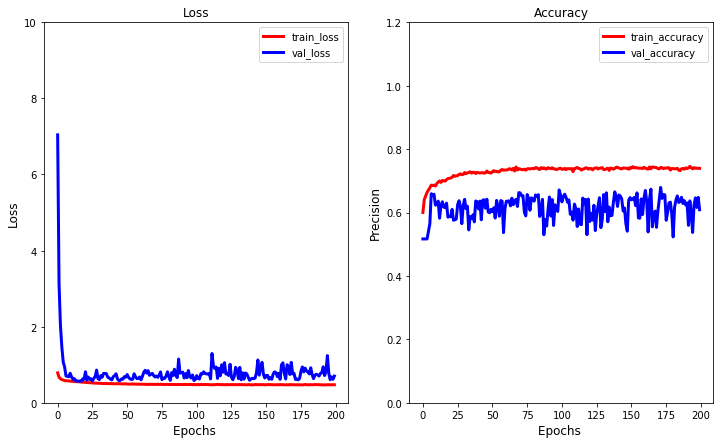

In [123]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [124]:
from metrics import confusion_matrix

### Training samples

In [125]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
                                               X_train_simpleClassifier, 
                                               y_train_simpleClassifier)

In [126]:
conf_matrix

array([[7127., 3315.],
       [2604., 7834.]])

In [127]:
print("Accuracy trainng: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall trainng: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion trainng: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy trainng: 71.65%
Recall trainng: 73.24%
Precicion trainng: 68.25%


### Testing samples

In [128]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, 
                                               X_test_simpleClassifier, 
                                               y_test_simpleClassifier)

In [129]:
conf_matrix

array([[2768., 1639.],
       [1882., 2711.]])

In [130]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 60.88%
Recall testing: 59.53%
Precicion testing: 62.81%


In [96]:
sys.exit()

SystemExit: 

/home/sergi/anaconda3/envs/PhD_GPU/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Analysing similaritis

In [107]:
from metrics import similarity_sequential_output_percentage_correct

In [108]:
equal, similar, incorrect = similarity_sequential_output_percentage_correct(model, X_test, y_test, 80)

/home/sergi/Documents/PhD_Castelldefels/RNN_v8_weather/metrics.py:149: RuntimeWarning: divide by zero encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample
/home/sergi/Documents/PhD_Castelldefels/RNN_v8_weather/metrics.py:149: RuntimeWarning: invalid value encountered in true_divide
  percentage_correct_predictions = sum_prediction / sum_test_sample


In [109]:
equal, similar, incorrect

(0.5426621160409556, 0.27303754266211605, 0.18430034129692832)

# From many-to-many to many-to-one

In [110]:
from metrics import detect_regulations_binary, updated_detect_regulations_binary

In [111]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = detect_regulations_binary(model, X_test, y_test)

In [112]:
conf_matrix_binary

array([[173.,  47.],
       [  0.,  66.]])

In [113]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 83.57%
Recall testing: 100.00%
Precicion testing: 78.64%


In [114]:
TP_binary, FP_binary, TN_binary, FN_binary, conf_matrix_binary = updated_detect_regulations_binary(model, 
                                                                                                   X_test, 
                                                                                                   y_test, 10)

In [115]:
conf_matrix_binary

array([[127.,  48.],
       [ 44.,  74.]])

In [116]:
print("Accuracy testing: %.2f" % ((TP_binary+TN_binary)/(TP_binary+FP_binary+FN_binary+TN_binary)*100) + "%")
print("Recall testing: %.2f" % (TP_binary/(TP_binary+FN_binary)*100) + "%")
print("Precicion testing: %.2f" % (TP_binary/(TP_binary+FP_binary)*100) + "%")

Accuracy testing: 68.60%
Recall testing: 74.27%
Precicion testing: 72.57%
